In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from math import ceil,sin,cos, atan2, pi, sqrt
import pandas as pd
from cartopy import crs, feature
import requests
from bs4 import BeautifulSoup

In [116]:
import geocoder # pip install geocoder
def locat_coord(Name,province):
    g = geocoder.bing(Name+' '+province, key=APIkey)
    results = g.json
    return results['lat'], results['lng']

In [117]:
APIkey = 'Apex3rPr59EmaffYxKvl4Ypz0tjZBthExXiz1Ha_pBDtD3Q7XL7l2nMs2Ba8fwZm '

# Pulling official data from Wikipedia 2021 updated census
url = 'https://en.wikipedia.org/wiki/List_of_municipalities_in_British_Columbia'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})
Data=pd.read_html(str(indiatable))
# convert list to dataframe
Data=pd.DataFrame(Data[0])
Data = Data.iloc[:-10]

Name = Data['Name'].iloc[:,0]
Pop = Data['2021 Canadian census[11]'].iloc[:,0]

d = {'Name': Name, 'Population':np.array(Pop)}
Urban = pd.DataFrame(data=d)

In [118]:
# Pulling official data from Washington Population Dataset
url = 'https://mrsc.org/Home/Research-Tools/Washington-City-and-Town-Profiles.aspx'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"full city-county-data table-interactive"})
Data=pd.read_html(str(indiatable))
# convert list to dataframe
Data=pd.DataFrame(Data[0])
Data = Data.iloc[0::3]

Name = Data['City']
Pop = Data['Population (2022)']
popu = []
for po in Pop:
    popu.append(int(po))
d = {'Name': Name, 'Population':popu}
Urban2 = pd.DataFrame(data=d)

In [119]:
lat = []
lon = []
for i in range(Urban.shape[0]):
    try:
        latn,lonn = locat_coord(Urban.Name.iloc[i],'BC')
        lat.append(latn)
        lon.append(lonn)
    except TypeError:
        print(Urban.Name.iloc[i])
        lat.append(0)
        lon.append(0)
Urban['Latitude'] = lat
Urban['Longitude'] = lon

Montrose


In [120]:
lat = []
lon = []
for i in range(Urban2.shape[0]):
    try:
        latn,lonn = locat_coord(Urban2.Name.iloc[i],'Washington')
        lat.append(latn)
        lon.append(lonn)
    except TypeError:
        print(Urban2.Name.iloc[i])
        lat.append(0)
        lon.append(0)
Urban2['Latitude'] = lat
Urban2['Longitude'] = lon

In [121]:
Urban = Urban[Urban.Latitude < 50.1]
Urban = Urban[Urban.Longitude > -125.4]
Urban = Urban[Urban.Longitude < -122]
Urban2 = Urban2[Urban2.Latitude > 47]
Urban2 = Urban2[Urban2.Longitude > -124]
Urban2 = Urban2[Urban2.Longitude < -122]
frames = [Urban, Urban2]

Urban = pd.concat(frames)

In [122]:
Urban = Urban[Urban.Population > 20000]

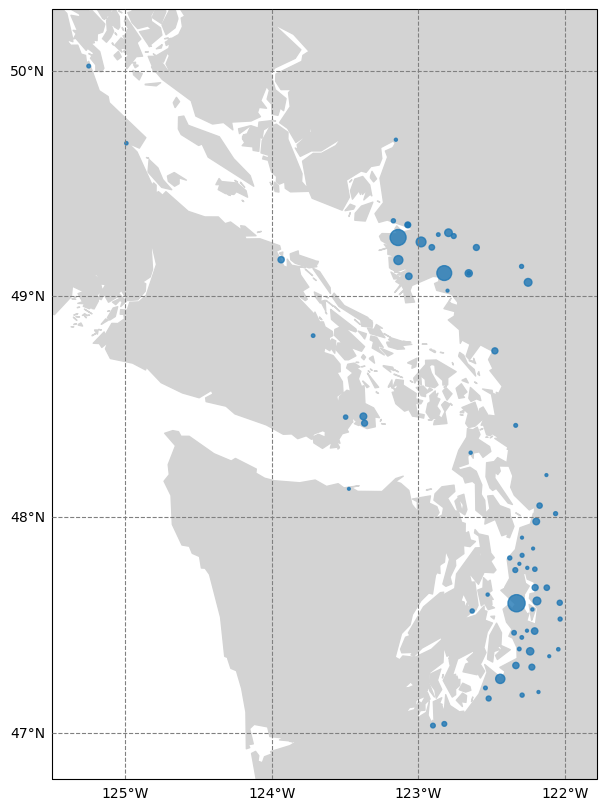

In [123]:
lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+0.25
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='lightgray',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False

sc=plt.scatter(Urban.Longitude,Urban.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Urban.Population/5e3)

In [130]:
Urban.shape

(68, 4)

In [131]:
import xarray as xr
from salishsea_tools import river_201702 as rivers

In [134]:
bathy = xr.open_dataset('../../../grid/bathymetry_202108.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/jvalenti/MOAD/grid/bathymetry_202108.nc'

In [133]:
rivers.prop_dict

{'howe': {'Squamish': {'prop': 0.9,
   'i': 534,
   'j': 384,
   'di': 1,
   'dj': 2,
   'depth': 2},
  'Burrard': {'prop': 0.1, 'i': 457, 'j': 343, 'di': 3, 'dj': 1, 'depth': 3}},
 'jdf': {'SanJuan': {'prop': 0.165,
   'i': 401,
   'j': 63,
   'di': 1,
   'dj': 1,
   'depth': 1},
  'Gordon': {'prop': 0.07, 'i': 404, 'j': 64, 'di': 1, 'dj': 1, 'depth': 1},
  'Loss': {'prop': 0.025, 'i': 376, 'j': 72, 'di': 1, 'dj': 1, 'depth': 1},
  'Jordan': {'prop': 0.025, 'i': 349, 'j': 97, 'di': 1, 'dj': 1, 'depth': 1},
  'Muir': {'prop': 0.025, 'i': 327, 'j': 120, 'di': 1, 'dj': 1, 'depth': 1},
  'Tugwell': {'prop': 0.025, 'i': 325, 'j': 121, 'di': 1, 'dj': 1, 'depth': 1},
  'Sooke': {'prop': 0.165, 'i': 316, 'j': 144, 'di': 1, 'dj': 1, 'depth': 1},
  'Elwha': {'prop': 0.15, 'i': 261, 'j': 134, 'di': 1, 'dj': 1, 'depth': 1},
  'Tumwater': {'prop': 0.003,
   'i': 248,
   'j': 151,
   'di': 1,
   'dj': 1,
   'depth': 1},
  'Valley': {'prop': 0.003, 'i': 247, 'j': 152, 'di': 1, 'dj': 1, 'depth': 1},
